In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Read data from csv file and preprocessing

Read the CSV file and observe the structure of the data. Since it only gives the timestamp and the speed of the corresponding time, so we need to do EDA(exploratory data analysis) and see which time data has a significant effect on the speed.

In [2]:
trafficFile = 'train.csv'
traffic = pd.read_csv(trafficFile, index_col="id", parse_dates=[1], dayfirst=True)
# traffic = traffic.drop(columns='id')
traffic.head()

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653


Based on EDA, we can discover that there is a big difference in the distribution of traffic speed between weekdays and weekends. Meanwhile, through the average velocity distribution, we can see that the velocity of identical months and each day within each month has a large fluctuation. So it's admirable to take month, date, day of week, and hour as the feature of the model, and also include the given timestamp as an analysis feature after normalization

In [3]:
traffic['hour'] = pd.to_datetime(traffic['date']).apply(lambda x: x.hour)
traffic['hour'] = traffic['hour']/23
traffic['weekday'] = pd.to_datetime(traffic['date']).apply(lambda x: x.dayofweek)
traffic['weekday'] = traffic['weekday']/6
traffic['month']=pd.to_datetime(traffic['date']).apply(lambda x:x.month)
traffic['month']=traffic['month']/12
traffic['day']=pd.to_datetime(traffic['date']).apply(lambda x:x.day)
traffic['day']=traffic['day']/30
max_time = max(traffic['date'])
min_time = min(traffic['date'])
traffic['time'] = (traffic['date']-min_time)/(max_time-min_time)

Set parameters for the dataset and split the original dataset into a training dataset and a testing one.

In [4]:
from sklearn.model_selection import train_test_split
X = traffic[['time','weekday','hour','month','day']]
y = traffic['speed']

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.001,random_state=0)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [9]:
my_model = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,
                            min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                           gamma=0,reg_alpha=0,reg_lambda=1,n_jobs=-1)
my_model.fit(x_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
importance = my_model.get_booster().get_score(importance_type='gain')

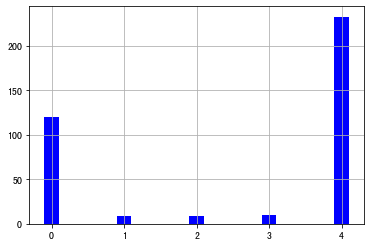

{'weekday': 120.30848082106291,
 'day': 8.594928379815231,
 'month': 8.630075875201245,
 'time': 9.49604624803486,
 'hour': 232.95631102267313}

In [21]:
for i, key in enumerate(importance):#Circulate both index and value(Here is key)
    plt.bar(i, importance[key], color='b', width=0.2)
plt.grid(True)
plt.show()
importance

From the above dictionary, we can find out the importance of above feature, 'hour' is the most important feature, followed by 'weekday', and the remaining features seem to have the same feature importance, so we need to keep all of them at the same time instead of eliminating them.

In [22]:
#predic with model
predictions = my_model.predict(x_test)

In [23]:
# measure the performance(mse)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions,y_test)))
print("Mean Squared Error : " + str(mean_squared_error(predictions,y_test)))
print("Score: " + str(my_model.score(x_test,y_test)))

Mean Absolute Error : 2.3759794262905274
Mean Squared Error : 9.42594714985498
Score: 0.9385824885129685


## Part2. Regression and Plot the result

In [24]:
def regression_method(model):
    model.fit(x_train,y_train)
    score = model.score(x_test, y_test)
    result = model.predict(x_test)
    ResidualSquare = (result - y_test)**2
    RSS = sum(ResidualSquare)
    MSE = np.mean(ResidualSquare)
    num_regress = len(result)
    print(f'n={num_regress}')
    print(f'R^2={score}')
    print(f'MSE={MSE}')
    print(f'RSS={RSS}')
    # Draw line chart to show the difference between the predicting value and actual value
    plt.figure(figsize=(20,8),dpi=80)
    # Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
    plt.plot(np.arange(len(result)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(result)),result,'ro-',label='predict value')
    plt.title('RandomForestRegression R^2: %f'%score)
    plt.legend()
    plt.show()
    return result,model

In [25]:
# Verify with scatter plot, points that are closer to the 1:1 line means that the corresponding predicting value is closer to its actual value
def scatter_plot(TureValues,PredictValues):
    # set the referenced 1:1 line
    xxx = [10,50]
    yyy = [10,50]
    plt.figure()
    plt.plot(xxx , yyy , c='0' , linewidth=1 , linestyle=':' , marker='.' , alpha=0.3)
    # scatter plot, whose x represents actural value and y represents predicting value
    plt.scatter(TureValues , PredictValues , s=20 , c='r' , edgecolors='k' , marker='o' , alpha=0.8)
    plt.xlim((10,50))
    plt.ylim((10,50))
    plt.title('RandomForestRegressionScatterPlot')
    plt.show()

In [26]:
my_model = xgb.XGBRegressor(learning_rate=0.1,n_estimators=500,max_depth=10,
                            min_child_weight=1,subsample=0.8,colsample_bytree=0.8,
                           gamma=0,reg_alpha=0,reg_lambda=1,n_jobs=-1)

n=15
R^2=0.9385824885129685
MSE=9.42594714985498
RSS=141.38920724782471


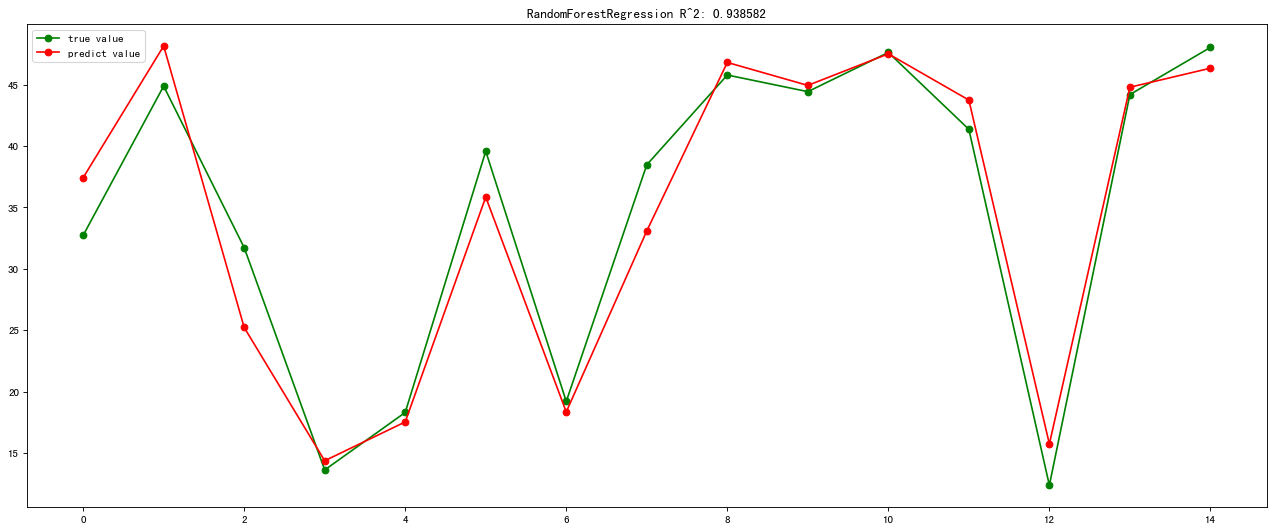

In [27]:
# get the predicting result, accuracy, and plot that represents difference between predicted value and actual value
y_pred,trained_model = regression_method(my_model)

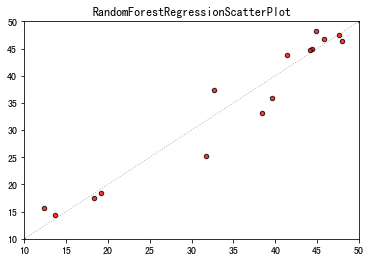

In [28]:
scatter_plot(y_test,y_pred)

## Part3. Apply all adjustments and see the improvement in performance

In [32]:
xgb_processed = xgb.XGBRegressor(learning_rate=0.1,n_estimators=184,max_depth=10,
                            min_child_weight=1,subsample=0.8,colsample_bytree=1.0,
                           gamma=0,reg_alpha=0,reg_lambda=1,n_jobs=-1)

n=15
R^2=0.9594620941964304
MSE=6.22148550826469
RSS=93.32228262397035


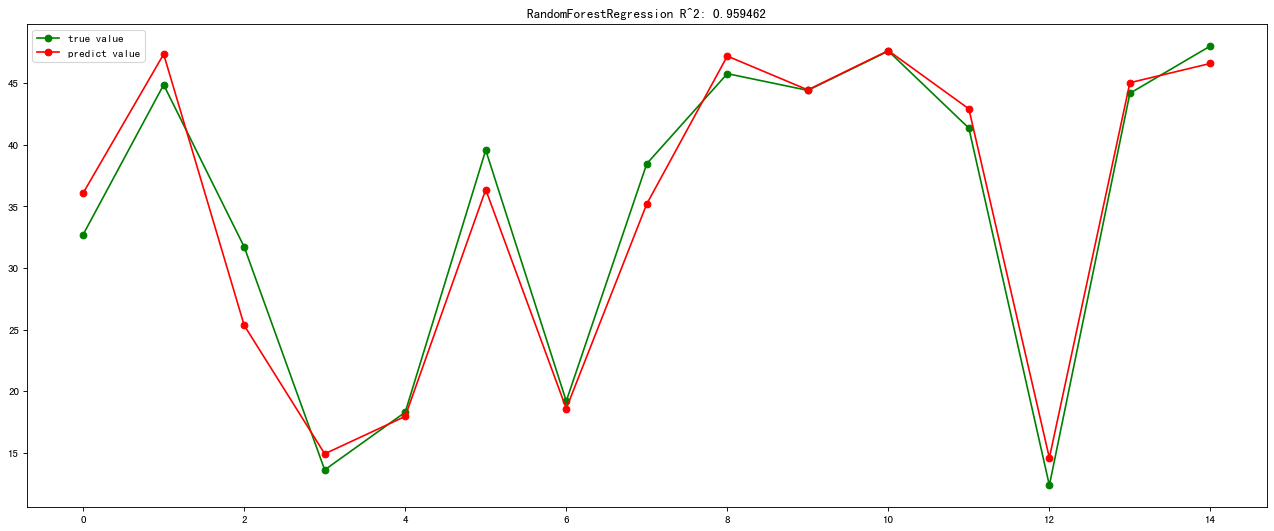

In [33]:
# get the trained model and apply it to data in 'test.csv'
y_pred,trained_model = regression_method(xgb_processed)

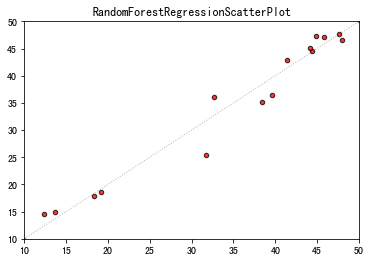

In [34]:
scatter_plot(y_test,y_pred)  #生成散点图

## Part 4. Read test data and get prediction result

In [35]:
data_test = pd.read_csv("test.csv", index_col='id', parse_dates=[1], dayfirst=True)
# data_test['datetime'] = pd.to_datetime(data_test['date'])
data_test['hour'] = pd.to_datetime(data_test['date']).apply(lambda x: x.hour)
data_test['hour'] = data_test['hour']/23
data_test['weekday'] = pd.to_datetime(data_test['date']).apply(lambda x: x.dayofweek)
data_test['weekday'] = data_test['weekday']/6
data_test['month'] = pd.to_datetime(data_test['date']).apply(lambda x:x.month)
data_test['month'] = data_test['month']/12
data_test['day'] = pd.to_datetime(data_test['date']).apply(lambda x:x.day)
data_test['day'] = data_test['day']/30
data_test['time'] = (data_test['date']-min_time)/(max_time-min_time)
data_test.head()

,date,hour,weekday,month,day,time
id,,,,,,
0,2018-01-01 02:00:00,0.086957,0.0,0.083333,0.033333,0.500228
1,2018-01-01 05:00:00,0.217391,0.0,0.083333,0.033333,0.500400
2,2018-01-01 07:00:00,0.304348,0.0,0.083333,0.033333,0.500514
3,2018-01-01 08:00:00,0.347826,0.0,0.083333,0.033333,0.500571
4,2018-01-01 10:00:00,0.434783,0.0,0.083333,0.033333,0.500685


In [36]:
predict_x = data_test[['time','weekday','hour','month','day']]
predict_x.shape

(3504, 5)

In [38]:
y = trained_model.predict(predict_x)

## Part6. Save results in the required form

In [39]:
y = y.reshape(-1,1)

index = np.arange(len(y))
index = index.reshape(-1,1)

df = pd.DataFrame(dict(date=data_test['date'].ravel(), id=index.ravel()))
df.drop(['date'], axis=1, inplace=True)
df = pd.DataFrame(dict(id=df['id'].ravel(), speed=y.ravel()))
df

,id,speed
0,0,48.948479
1,1,47.953041
2,2,38.485561
3,3,30.815825
4,4,39.893944
...,...,...
3499,3499,13.648241
3500,3500,23.391319
3501,3501,46.003510
3502,3502,39.712788


In [41]:
df.to_csv("xgboost_model1_pred.csv",index=False)